<h1>Worked machine learning examples using SDSS data</h1>

[AstroHackWeek 2014, 2016- J. S. Bloom @profjsb]

<hr>
Here we'll see some worked ML examples using `scikit-learn` on Sloan Digital Sky Survey Data (SDSS). This *should* work in both Python 2 and Python 3.

It's easiest to grab data from the <a href="http://skyserver.sdss3.org/public/en/tools/search/sql.aspx">SDSS skyserver SQL</a> server.


For example to do a basic query to get two types of photometry (aperature and petrosian), corrected for extinction, for 1000 QSO sources with redshifts:
<font color="blue">
 <pre>SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 1000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE 
 (class = 'QSO')
 ) as sp
 </pre>
 </font>
Saving this and others like it as a `csv` we can then start to make our data set for classification/regression.

In [1]:
## get the data locally ... I put this on a gist
!curl -k -O https://gist.githubusercontent.com/anonymous/53781fe86383c435ff10/raw/4cc80a638e8e083775caec3005ae2feaf92b8d5b/qso10000.csv
!curl -k -O https://gist.githubusercontent.com/anonymous/2984cf01a2485afd2c3e/raw/964d4f52c989428628d42eb6faad5e212e79b665/star1000.csv
!curl -k -O https://gist.githubusercontent.com/anonymous/2984cf01a2485afd2c3e/raw/335cd1953e72f6c7cafa9ebb81b43c47cb757a9d/galaxy1000.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2378k  100 2378k    0     0  1313k      0  0:00:01  0:00:01 --:--:-- 1713k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239k  100  239k    0     0   267k      0 --:--:-- --:--:-- --:--:--  268k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  229k  100  229k    0     0   410k      0 --:--:-- --:--:-- --:--:--  413k


In [4]:
## Python 2 backward compatibility
from __future__ import absolute_import, division, print_function, unicode_literals

In [11]:
# For pretty plotting, pandas, sklearn
!conda install pandas seaborn  matplotlib scikit-learn==0.17.1 -y 

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /Users/jbloom/anaconda/envs/seminar:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.7.1              |           py35_0         282 KB

The following NEW packages will be INSTALLED:

    seaborn: 0.7.1-py35_0

Fetching packages ...
seaborn-0.7.1- 100% |################################| Time: 0:00:00 307.65 kB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|###################################################| 100%


In [6]:
import copy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20

import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
sns.set()

In [7]:
pd.read_csv("qso10000.csv",index_col=0).head()

,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z
objid,,,,,,,,,,,,,,,,,,,,,,,
1237648720142532813,146.90229,-0.984913,19.64289,19.31131,19.25328,19.15353,19.13345,19.71604,19.37595,19.32818,19.24847,19.21259,0.652417,0.331583,0.058027,0.099751,0.020077,QSO,-0.073151,-0.064648,-0.074903,-0.094942,-0.079136
1237658425156829371,142.45853,6.646406,19.39569,19.34811,19.16626,18.93152,19.06013,19.40327,19.36566,19.18335,18.94222,19.08077,1.537123,0.047575,0.181847,0.234743,-0.128612,QSO,-0.007589,-0.017550,-0.017090,-0.010700,-0.020636
1237660413189095710,143.15770,8.175363,19.10362,18.88904,18.70672,18.58508,18.61328,19.11102,18.88857,18.70458,18.57886,18.62583,1.467101,0.214582,0.182318,0.121645,-0.028202,QSO,-0.007397,0.000473,0.002148,0.006218,-0.012548
1237660412651962520,142.49264,7.800945,19.88820,19.75146,19.52941,19.65000,19.52470,19.88709,19.75292,19.53512,19.67052,19.50256,1.014217,0.136745,0.222052,-0.120590,0.125301,QSO,0.001118,-0.001457,-0.005716,-0.020527,0.022139
1237658493336944662,142.64367,7.917698,18.45897,18.40651,18.15901,17.77130,17.75986,18.55725,18.55002,18.40316,18.01008,18.03100,0.215603,0.052462,0.247498,0.387709,0.011444,QSO,-0.098282,-0.143515,-0.244150,-0.238779,-0.271137


Notice that there are several things about this dataset. First, RA and DEC are probably not something we want to use in making predictions: it's the location of the object on the sky. Second, the magnitudes are highly covariant with the colors. So dumping all but one of the magnitudes might be a good idea to avoid overfitting. 

In [14]:
usecols = [str(x) for x in ["objid","dered_r","spec_z","u_g_color","g_r_color","r_i_color",
           "i_z_color","diff_u",\
           "diff_g1","diff_i","diff_z"]]

qsos = pd.read_csv("qso10000.csv",index_col=0,
                                  usecols=usecols)

qso_features = copy.copy(qsos)
qso_redshifts = qsos["spec_z"]
del qso_features["spec_z"]
qso_features.head()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237648720142532813,19.25328,0.331583,0.058027,0.099751,0.020077,-0.073151,-0.074903,-0.094942,-0.079136
1237658425156829371,19.16626,0.047575,0.181847,0.234743,-0.128612,-0.007589,-0.017090,-0.010700,-0.020636
1237660413189095710,18.70672,0.214582,0.182318,0.121645,-0.028202,-0.007397,0.002148,0.006218,-0.012548
1237660412651962520,19.52941,0.136745,0.222052,-0.120590,0.125301,0.001118,-0.005716,-0.020527,0.022139
1237658493336944662,18.15901,0.052462,0.247498,0.387709,0.011444,-0.098282,-0.244150,-0.238779,-0.271137


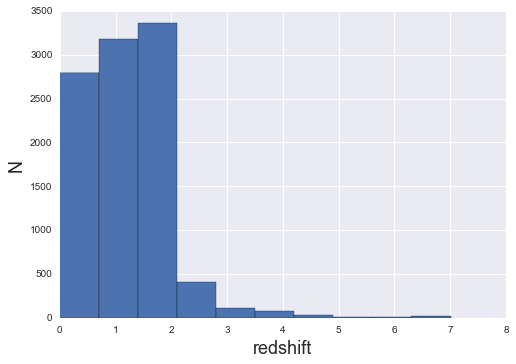

In [15]:
f, ax = plt.subplots()
bins =  ax.hist(qso_redshifts.values)
ax.set_xlabel("redshift", fontsize=18)
ax.set_ylabel("N",fontsize=18)

Pretty clearly a big cut at around $z=2$.

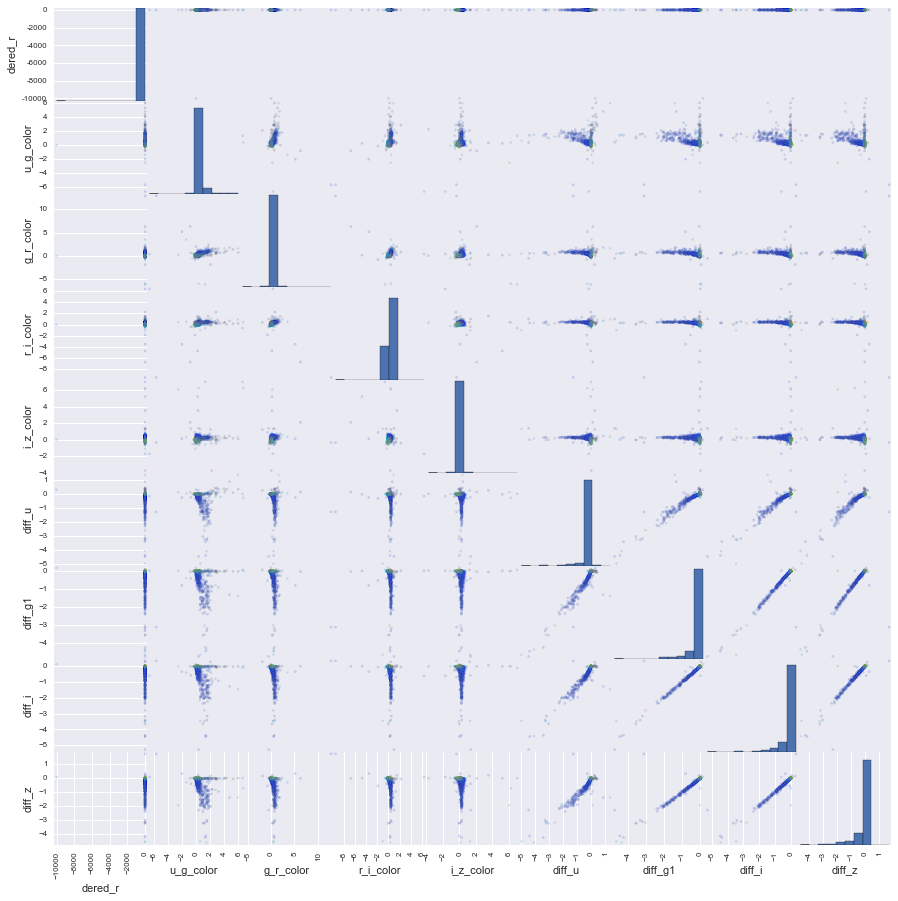

In [16]:
import matplotlib as mpl
import matplotlib.cm as cm
## truncate the color at z=2.5 just to keep some contrast.
norm = mpl.colors.Normalize(vmin=min(qso_redshifts.values), vmax=2.5)
cmap = cm.jet
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rez = pd.scatter_matrix(qso_features[0:2000], 
                        alpha=0.2,figsize=[15,15],color=m.to_rgba(qso_redshifts.values))

Egad. Some pretty crazy values for `dered_r` and `g_r_color`. Let's figure out why.

In [17]:
min(qso_features["dered_r"].values)

-9999.0

Looks like there are some missing values in the catalog which are set at -9999. Let's zoink those from the dataset for now.

In [18]:
qsos = pd.read_csv("qso10000.csv",index_col=0,
                                  usecols=usecols)

qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10)]
qso_features = copy.copy(qsos)
qso_redshifts = qsos["spec_z"]
del qso_features["spec_z"]

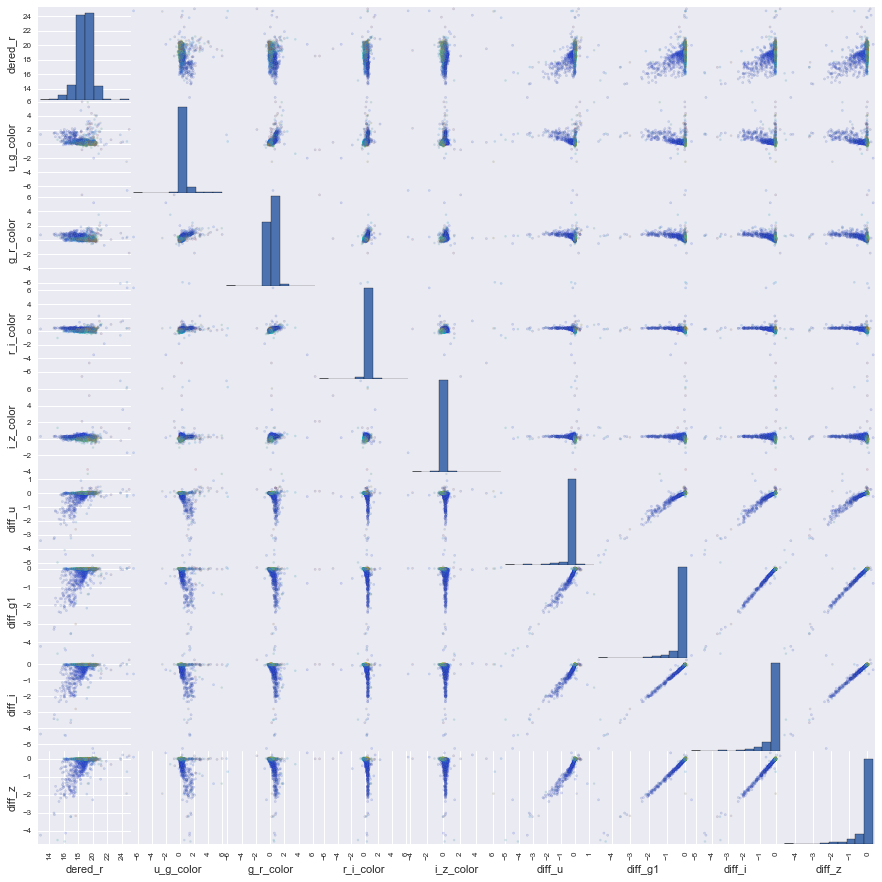

In [19]:
rez = pd.scatter_matrix(qso_features[0:2000], alpha=0.2,figsize=[15,15],\
                        color=m.to_rgba(qso_redshifts.values))

Ok. This looks pretty clean. Let's save this for future use.

In [20]:
qsos.to_csv("qsos.clean.csv")

## Data Munging done. Let's do some ML!

### Basic Model Fitting

We need to create a **training set** and a **testing set**.

In [21]:
X = qso_features.values  # 9-d feature space
Y = qso_redshifts.values # redshifts

In [22]:
print("feature vector shape=", X.shape)
print("class shape=", Y.shape)

feature vector shape= (9988, 9)
class shape= (9988,)


In [23]:
# half of data
import math
half = math.floor(len(Y)/2)
train_X = X[:half]
train_Y = Y[:half]
test_X = X[half:]
test_Y = Y[half:]

/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


** Linear Regression **

http://scikit-learn.org/stable/modules/linear_model.html

In [24]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

In [ ]:
clf.

In [25]:
# fit the model
clf.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# now do the prediction
Y_lr_pred = clf.predict(test_X)

# how well did we do?
from sklearn.metrics import mean_squared_error
mse = np.sqrt(mean_squared_error(test_Y,Y_lr_pred)) ; print("MSE",mse)

MSE 0.659053404786


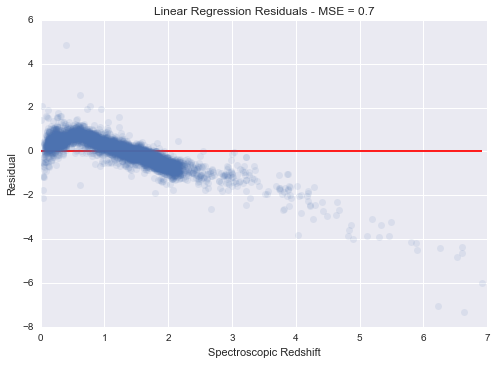

In [27]:
plt.plot(test_Y,Y_lr_pred - test_Y,'o',alpha=0.1)
plt.title("Linear Regression Residuals - MSE = %.1f" % mse)
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(test_Y),max(test_Y),color="red")

In [28]:
# here's the MSE guessing the AVERAGE value
print("naive mse", ((1./len(train_Y))*(train_Y - train_Y.mean())**2).sum())

naive mse 0.643120844956


In [29]:
mean_squared_error?

** *k*-Nearest Neighbor (KNN) Regression **

In [30]:
from sklearn import neighbors
from sklearn import preprocessing
X_scaled = preprocessing.scale(X) # many methods work better on scaled X
clf1 = neighbors.KNeighborsRegressor(10)
train_X = X_scaled[:half]
test_X = X_scaled[half:]
clf1.fit(train_X,train_Y)

/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

MSE (KNN) 0.234493621244


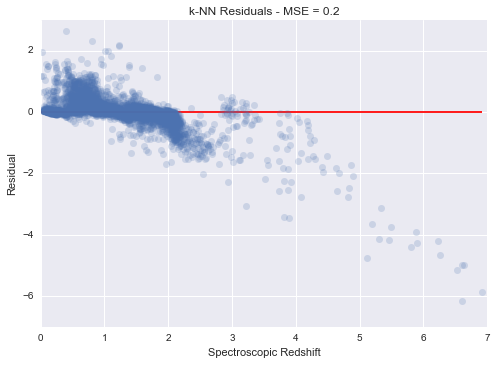

In [31]:
Y_knn_pred = clf1.predict(test_X)
mse = mean_squared_error(test_Y,Y_knn_pred) ; print("MSE (KNN)", mse)
plt.plot(test_Y, Y_knn_pred - test_Y,'o',alpha=0.2)
plt.title("k-NN Residuals - MSE = %.1f" % mse)
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(test_Y),max(test_Y),color="red")

In [32]:
from sklearn import neighbors
from sklearn import preprocessing

X_scaled = preprocessing.scale(X) # many methods work better on scaled X
train_X = X_scaled[:half]
train_Y = Y[:half]
test_X = X_scaled[half:]
test_Y = Y[half:]
clf1 = neighbors.KNeighborsRegressor(5)
clf1.fit(train_X,train_Y)

/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jbloom/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

MSE= 0.239666881833


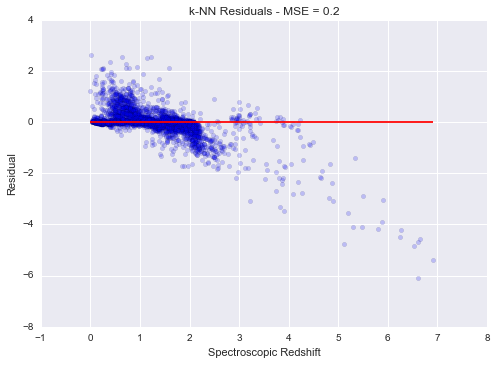

In [33]:
Y_knn_pred = clf1.predict(test_X)
mse = mean_squared_error(test_Y,Y_knn_pred) ; print("MSE=",mse)
plt.scatter(test_Y, Y_knn_pred - test_Y,alpha=0.2)
plt.title("k-NN Residuals - MSE = %.1f" % mse)
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(test_Y),max(test_Y),color="red")

#### Random Forests
Pretty good intro
http://blog.yhathq.com/posts/random-forests-in-python.html

In [34]:
from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=100, 
                            criterion='mse', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_leaf_nodes=None, 
                            bootstrap=True, oob_score=False, n_jobs=1, 
                            random_state=None, verbose=0, warm_start=False)
clf2.fit(train_X,train_Y)

RandomForestRegressor(bootstrap=True, criterion=u'mse', max_depth=None,
           max_features=u'auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

MSE 0.202454102592


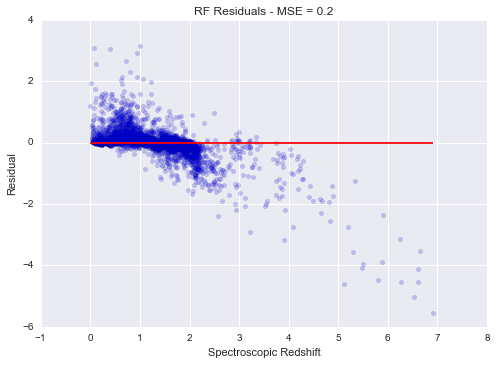

In [35]:
Y_rf_pred = clf2.predict(test_X)
mse = mean_squared_error(test_Y,Y_rf_pred) ; print("MSE",mse)
plt.scatter(test_Y, Y_rf_pred - test_Y,alpha=0.2)
plt.title("RF Residuals - MSE = %.1f" % mse)
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(test_Y),max(test_Y),color="red")

## model selection: cross-validation

In [36]:
from sklearn import cross_validation

In [37]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
from sklearn.cross_validation import cross_val_score

def print_cv_score_summary(model, xx, yy, cv):
    scores = cross_val_score(model, xx, yy, cv=cv, n_jobs=1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [38]:
print_cv_score_summary(clf,X,Y,cv=cross_validation.KFold(len(Y), 5))

mean: 0.237593, stdev: 0.026459


In [39]:
print_cv_score_summary(clf,X,Y,
    cv=cross_validation.KFold(len(Y),10,shuffle=True,random_state=1))

mean: 0.246604, stdev: 0.041721


In [40]:
print_cv_score_summary(clf2,X,Y,
    cv=cross_validation.KFold(len(Y),3,shuffle=True,random_state=1))

mean: 0.601922, stdev: 0.023209


## Classification

Let's do a 3-class classification problem: star, galaxy, or QSO

In [43]:
usecols = [str(x) for x in ["objid","dered_r","u_g_color","g_r_color","r_i_color","i_z_color","diff_u",\
           "diff_g1","diff_i","diff_z","class"]]

all_sources = pd.read_csv("qso10000.csv",index_col=0,usecols=usecols)[:1000]

all_sources = all_sources.append(pd.read_csv("star1000.csv",index_col=0,usecols=usecols))

all_sources = all_sources.append(pd.read_csv("galaxy1000.csv",index_col=0,usecols=usecols))

all_sources = all_sources[(all_sources["dered_r"] > -9999) & (all_sources["g_r_color"] > -10) & (all_sources["g_r_color"] < 10)]
all_features = copy.copy(all_sources)
all_label = all_sources["class"]
del all_features["class"]
X = copy.copy(all_features.values)
Y = copy.copy(all_label.values)

In [44]:
all_sources.tail()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237657775542632759,15.42325,1.999353,0.970126,0.435975,0.373470,-1.944487,-1.971534,-2.052320,-1.971382
1237657775542698090,17.51366,2.212025,0.965242,0.410664,0.371384,-0.778788,-0.944075,-0.895832,-0.830559
1237657775542698177,17.15747,1.190033,0.332136,0.252352,0.070980,-2.391565,-2.977261,-2.889906,-2.671612
1237657630586634463,17.19312,1.179663,0.678915,0.394419,0.272171,-1.563450,-1.913368,-1.791895,-1.615683
1237657630049698007,17.20485,1.925320,1.126934,0.477961,0.334377,-1.211906,-1.377165,-1.402037,-1.218332


In [45]:
print("feature vector shape=", X.shape)
print("class shape=", Y.shape)

feature vector shape= (3000, 9)
class shape= (3000,)


In [46]:
Y[Y=="QSO"] = 0
Y[Y=="STAR"] = 1
Y[Y=="GALAXY"] = 2
Y = list(Y)

Let's look at random forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200,oob_score=True)
clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

what are the important features in the data?

In [48]:
sorted(zip(all_sources.columns.values,clf.feature_importances_),key=lambda q: q[1],reverse=True)

[('u_g_color', 0.26258480958434571),
 ('diff_i', 0.16541030117105393),
 ('diff_g1', 0.15483352159605107),
 ('diff_z', 0.12061964529166984),
 ('g_r_color', 0.085033386405546099),
 ('diff_u', 0.068554012091952346),
 ('r_i_color', 0.06077107102833585),
 ('dered_r', 0.046825658066310588),
 ('i_z_color', 0.03536759476473475)]

In [49]:
clf.oob_score_ ## "Out of Bag" Error

0.95299999999999996

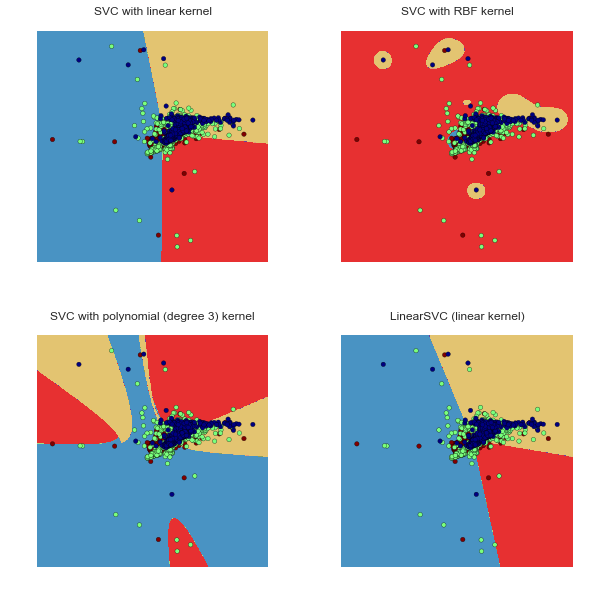

In [52]:
import numpy as np
from sklearn import svm, datasets
cmap = cm.jet_r

# import some data to play with

plt.figure(figsize=(10,10))

X = all_features.values[:, 1:3] # use only two features for training and plotting purposes

h = 0.02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel=str('linear'), C=C).fit(X, Y)
rbf_svc = svm.SVC(kernel=str('rbf'), gamma=0.7, C=C).fit(X, Y)
poly_svc = svm.SVC(kernel=str('poly'), degree=3, C=C).fit(X, Y)
lin_svc = svm.LinearSVC(C=C).fit(X, Y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'LinearSVC (linear kernel)']


norm = mpl.colors.Normalize(vmin=min(Y), vmax=max(Y))
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, clf in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z,cmap=cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=m.to_rgba(Y),cmap=cm.Paired)

    plt.title(titles[i])

## model improvement with GridSearchCV

Hyperparameter optimization. Parallel: makes use of `joblib`

In [53]:
# fit a support vector machine classifier
from sklearn import grid_search
from sklearn import svm
from sklearn import metrics
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# instantiate the SVM object
sdss_svm = svm.SVC()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'kernel':(str('linear'), str('rbf')), \
              'gamma':[0.5, 0.3, 0.1,  0.01],
              'C':[0.1, 2, 4, 5, 10, 20,30]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
svm_tune = grid_search.GridSearchCV(sdss_svm, parameters,\
                                    n_jobs = -1, cv = 3,verbose=1)
svm_opt = svm_tune.fit(X, Y)

# print the best score and estimator
print(svm_opt.best_score_)
print(svm_opt.best_estimator_)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   10.6s finished


0.955
SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[[231   1   1]
 [  7 254  19]
 [  3   9 225]]


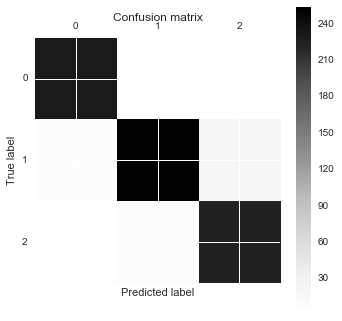

In [54]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

classifier = svm.SVC(**svm_opt.best_estimator_.get_params())
y_pred = classifier.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
# instantiate the RF learning object
sdss_rf = RandomForestClassifier()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'n_estimators':(10,50,200),"max_features": ["auto",3,5],
              'criterion':[str("gini"),str("entropy")],"min_samples_leaf": [1,2]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
rf_tune = grid_search.GridSearchCV(sdss_rf, parameters,\
                                    n_jobs = -1, cv = 3,verbose=1)
rf_opt = rf_tune.fit(X, Y)

# print the best score and estimator
print(rf_opt.best_score_)
print(rf_opt.best_estimator_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   43.4s finished


0.949
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=u'auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [56]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [57]:
svm_opt.best_estimator_.get_params()

{'C': 20,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [96]:
grid_search.GridSearchCV?

## Parallelism & Hyperparameter Fitting

GridSearchCV is not compute/RAM optimized. It's also not obviously optimal.

In [58]:
import time
start = time.time()
## this takes about 30 seconds

# instantiate the RF learning object
sdss_rf = RandomForestClassifier()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'n_estimators':(10,50,200),"max_features": ["auto",3,5],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
rf_tune = grid_search.GridSearchCV(sdss_rf, parameters,\
                                    n_jobs = -1, cv = 3,verbose=1)
rf_opt = rf_tune.fit(X, Y)

# print the best score and estimator
print(rf_opt.best_score_)
print(rf_opt.best_estimator_)
print("total time in seconds",time.time()- start)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   39.8s finished


0.949
RandomForestClassifier(bootstrap=True, class_weight=None, criterion=u'gini',
            max_depth=None, max_features=u'auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
total time in seconds 42.2648029327


Let's do this without a full search...

In [59]:
import time
start = time.time()

# instantiate the RF learning object
sdss_rf = RandomForestClassifier()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'n_estimators':(10,50,200),"max_features": ["auto",3,5],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
rf_tune = grid_search.RandomizedSearchCV(sdss_rf, parameters,\
                                    n_jobs = -1, cv = 3,verbose=1)
rf_opt = rf_tune.fit(X, Y)

# print the best score and estimator
print(rf_opt.best_score_)
print(rf_opt.best_estimator_)
print("total time in seconds",time.time()- start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.0s finished


0.948666666667
RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion=u'entropy', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
total time in seconds 8.31015610695


In [14]:
!conda install dask distributed -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /Users/jbloom/anaconda/envs/seminar:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    click-6.6                  |           py35_0         100 KB
    docutils-0.12              |           py35_2         668 KB
    jmespath-0.9.0             |           py35_0          28 KB
    lz4-0.8.2                  |           py35_0          28 KB
    msgpack-python-0.4.7       |           py35_0          69 KB
    psutil-4.3.0               |           py35_0         218 KB
    tblib-1.3.0                |           py35_0          12 KB
    botocore-1.4.37            |           py35_0         1.9 MB
    boto3-1.3.1                |           py35_0          97 KB
    s3fs-0.0.7                 |           py35_0          24 KB
    distributed-1.12.0         |           py

In [60]:
import os
myhome = os.getcwd()

In [61]:
os.environ["PYTHONPATH"] = myhome + "/dask-learn"

In [62]:
myhome = !pwd
!git clone https://github.com/dask/dask-learn.git
%cd dask-learn
!git pull
!python setup.py install

fatal: destination path 'dask-learn' already exists and is not an empty directory.
/Users/jbloom/Classes/day4/dask-learn
Already up-to-date.
running install
running bdist_egg
running egg_info
writing requirements to dask_learn.egg-info/requires.txt
writing top-level names to dask_learn.egg-info/top_level.txt
writing dask_learn.egg-info/PKG-INFO
writing dependency_links to dask_learn.egg-info/dependency_links.txt
reading manifest file 'dask_learn.egg-info/SOURCES.txt'
writing manifest file 'dask_learn.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.6-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.6-x86_64/egg
creating build/bdist.macosx-10.6-x86_64/egg/dklearn
copying build/lib/dklearn/__init__.py -> build/bdist.macosx-10.6-x86_64/egg/dklearn
copying build/lib/dklearn/averaged.py -> build/bdist.macosx-10.6-x86_64/egg/dklearn
copying build/lib/dklearn/chained.py -> build/bdist.macosx-10.6-x86_64/egg/dklearn
copying build/lib/dklearn/

In [63]:
from dklearn.grid_search import GridSearchCV as DaskGridSearchCV

In [64]:
import time
start = time.time()
# instantiate the RF learning object
sdss_rf = RandomForestClassifier()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'n_estimators':(10,50,200),"max_features": ["auto",3,5],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
rf_tune = DaskGridSearchCV(sdss_rf, parameters,\
                                    cv = 3)
rf_opt = rf_tune.fit(X, Y)

# print the best score and estimator
print(rf_opt.best_score_)
print(rf_opt.best_estimator_)
print("total time in seconds",time.time()- start)

0.95
RandomForestClassifier(bootstrap=True, class_weight=None, criterion=u'gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
total time in seconds 66.4075751305


In [17]:
#To do distributed:
#from distributed import Executor
#executor = Executor()
#executor

<Executor: scheduler="127.0.0.1:52744" processes=3 cores=3>